In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.mlab as mlab
import time
import json
import pandas as pd
import requests
from pandas import json_normalize
import os
import csv
pd.options.mode.chained_assignment = None
import seaborn as sns
import scikitplot as skplt
import scipy  
from scipy.cluster import hierarchy as hc
from collections import defaultdict
from rfpimp import *

# Machine learning
from sklearn import preprocessing, model_selection, svm, metrics
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier as sgd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

from dtreeviz.trees import *
 
# Then run the code below if you get an error telling you that graphviz isn't in your system path (Windows users)
# https://stackoverflow.com/a/44625895
import os
your_graphviz_install_directory = 'C:/Users/bosem/anaconda3/Library/bin/graphviz'
os.environ["PATH"] += os.pathsep + your_graphviz_install_directory

C:\Users\bosem\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
path = os.getcwd()
pathname = path + "\\" + "shotsbar201819.csv"
shots = pd.read_csv(pathname)

In [3]:
# Total number of rows and columns
len(shots),len(list(shots))

(10235, 45)

In [4]:
# Uncomment to see the first few lines of the dataframe
# shots.head()

In [3]:
#Separate the features that define xG, and the label,i.e. goal

features = shots.drop('goal', axis=1)
labels = shots['goal']
 
# Encode categorical features
cont_cols = ['duration', 'pass_angle', 'pass_length', 'distance', 
             'angle', 'shot_cone', 'distance_to_nearest_opponent']
 
cat_features = features.drop(cont_cols, axis=1)
cont_features = features[cont_cols]

def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df.head(20).transpose())

# Use label encoding to convert categorical features to numeric
# https://stackoverflow.com/a/37038257
def label_encode(df):
    # Convert df to label encoded
    df_le = pd.DataFrame({col: df[col].astype('category').cat.codes for col in df}, index=df.index)
    # Save mappings as a dict
    mappings = {col: {n: cat for n, cat in enumerate(df[col].astype('category').cat.categories)} 
     for col in df}
    return df_le, mappings
 
cat_features_le, mappings = label_encode(cat_features)
 
# Merge with numeric features
features_le = cont_features.merge(cat_features_le, left_index=True, right_index=True)
 
# Note that missing categorical features have been set to -1 automatically. 
# Although I don't see any, probably because nothing was missing from before. 

# display_all(features_le)

In [4]:
trainX = features_le
trainy = labels

In [11]:
m = SVC(probability=True, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
 
# Define a function to calculate the Brier loss using cross-validation
def get_loss(X, y=trainy, m=m, cv=cv):
    scores = cross_val_score(m, X, y, cv=cv, scoring='brier_score_loss')
    return np.mean(scores)*-1
 
loss = get_loss(X=trainX)
print('Brier loss:', "{0:.5f}".format(loss))

Brier loss: 0.11317


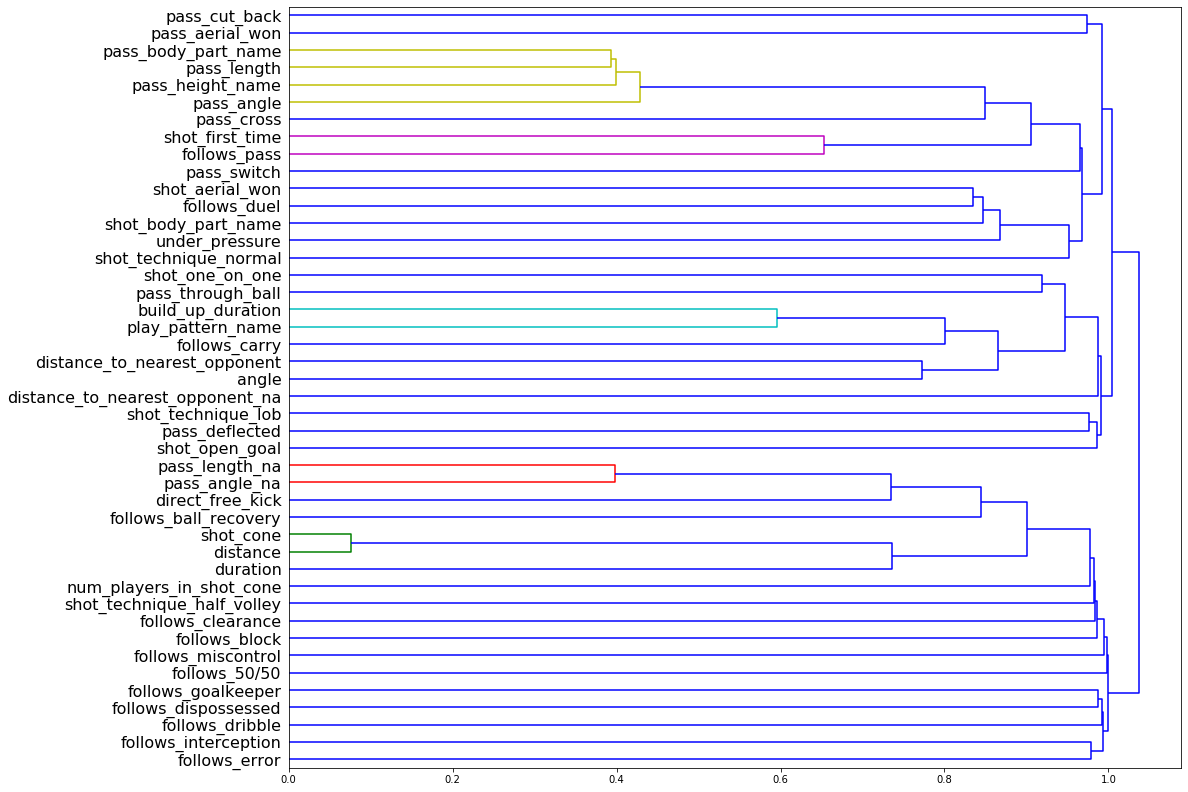

In [18]:
from numpy.random import rand
from numpy.random import seed
seed(42)
copyX = trainX + rand(*trainX.shape) / 100000.0
# Create dendrogram to show correlations between features
# np.seterr(divide='ignore', invalid='ignore')
def dendrogram(X):
    # Compare features using rank correlation
    # https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient
    corr = np.round(scipy.stats.spearmanr(X).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=(16,14))
    dendrogram = hc.dendrogram(z, labels=X.columns, 
          orientation='right', leaf_font_size=16)
    plt.show()
    return

dendrogram(copyX)
# # np.seterr(divide='ignore', invalid='ignore')
# corr = np.round(scipy.stats.spearmanr(copyX).correlation, 4)
# corr_condensed = hc.distance.squareform(1-corr)
# corr_condensed

In [20]:
X = features_le
y = labels
 
rm = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
 
# Define a function to calculate the Brier loss using cross-validation
def get_loss(X, y=y, rm=rm, cv=cv):
    scores = cross_val_score(rm, X, y, cv=cv, scoring='brier_score_loss')
    return np.mean(scores)*-1
 
loss = get_loss(X=X)
print('Brier loss:', "{0:.5f}".format(loss))

Brier loss: 0.08747


In [28]:
m.fit(trainX,trainy)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [43]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42, n_jobs=-1)
xgb.fit(trainX, trainy)
scores = cross_val_score(xgb, trainX, trainy, cv=cv, scoring='brier_score_loss')
print('Brier loss:', "{0:.5f}".format(np.mean(scores)*-1))

Brier loss: 0.08942


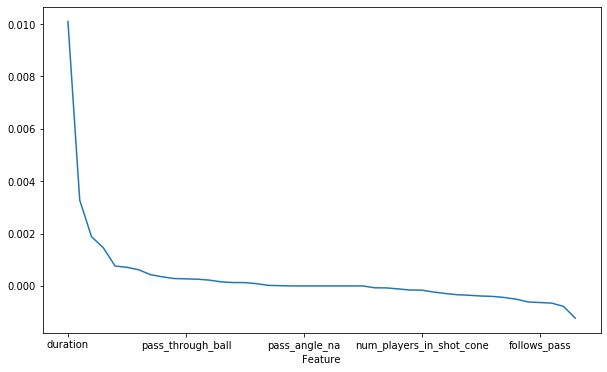

In [49]:
def get_loss2(X, y=trainy, xgb=xgb, cv=cv):
    scores = cross_val_score(xgb, X, y, cv=cv, scoring='brier_score_loss')
    return np.mean(scores)*-1

# Define a function to get feature importance using the drop-column method
def get_imp(X, y=trainy, xgb=xgb, cv=cv):
    baseline = get_loss2(X=X, y=y, xgb=xgb, cv=cv)
    imp = []
    for col in X.columns:
        s = get_loss2(X=X.drop(col, axis=1), y=y, xgb=xgb, cv=cv)
        change_in_score = s - baseline
        imp.append(change_in_score)
    imp_df = pd.DataFrame(data={'Feature': X.columns, 'Importance': np.array(imp)})
    imp_df = imp_df.set_index('Feature').sort_values('Importance', ascending=False)
    return imp_df

imp1 = get_imp(X=trainX)
imp1.reset_index().plot('Feature', 'Importance', figsize=(10,6), legend=False);

In [56]:
# Define function to eliminate features that fall below a certain threshold
def elim_feats(X, imp, thresh):
    return X[list(imp[imp.values>thresh].index.values)]

# Create a list of 11 thresholds, evenly spaced between 0 and 0.0005
thresholds = [float(x) for x in np.linspace(start=-0.0005, stop=0.0, num=11)]

# Calculate the loss for each threshold in the list
print('Original Brier loss:', "{0:.5f}".format(loss1))
for thresh in thresholds:
    X_elim = elim_feats(X=trainX, imp=imp1, thresh=thresh)
    loss_elim = get_loss2(X=X_elim)
    print('Threshold:', "{0:.10f}".format(thresh), 'Brier loss:', "{0:.10f}".format(loss_elim))

Original Brier loss: 0.08973
Threshold: -0.0005000000 Brier loss: 0.0886947742
Threshold: -0.0004500000 Brier loss: 0.0886947742
Threshold: -0.0004000000 Brier loss: 0.0904058459
Threshold: -0.0003500000 Brier loss: 0.0908661689
Threshold: -0.0003000000 Brier loss: 0.0907261264
Threshold: -0.0002500000 Brier loss: 0.0909740765
Threshold: -0.0002000000 Brier loss: 0.0903754592
Threshold: -0.0001500000 Brier loss: 0.1012534686
Threshold: -0.0001000000 Brier loss: 0.1007633747
Threshold: -0.0000500000 Brier loss: 0.1016475056
Threshold: 0.0000000000 Brier loss: 0.1010912339


Brier loss: 0.08869


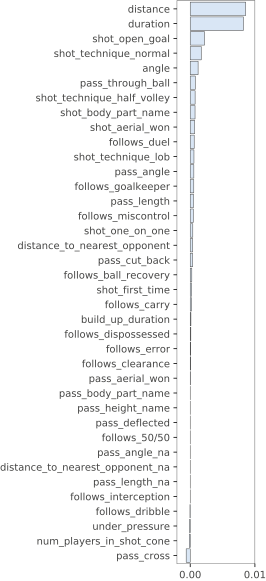

In [57]:
# Eliminate features below 0.00015 importance and rerun the model
X2 = elim_feats(X=trainX, imp=imp1, thresh=-0.00045)

loss2 = get_loss2(X=X2)
imp2 = get_imp(X=X2)
print('Brier loss:', "{0:.5f}".format(loss2))
plot_importances(imp2, imp_range=(min(imp2.values), max(imp2.values)))

Brier loss: 0.08940


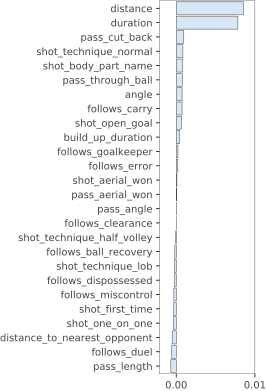

In [58]:
# Eliminate features <=0 importance and re-run the model
X3 = elim_feats(X=X2, imp=imp2, thresh=0)
# Also get rid of pass_angle_na, as pass_angle is no longer a model feature
# X4 = X4.drop('pass_angle_na', axis=1)

loss3 = get_loss2(X=X3)
imp3 = get_imp(X=X3)
print('Brier loss:', "{0:.5f}".format(loss3))
plot_importances(imp3, imp_range=(min(imp3.values), max(imp3.values)))

In [44]:
pathname2 = path + "\\" + "shots201819.csv"
shots201819 = pd.read_csv(pathname2)

In [45]:
#Separate the features that define xG, and the label,i.e. goal

features2 = shots201819.drop('goal', axis=1)
labels2 = shots201819['goal']
 
# Encode categorical features
cont_cols2 = ['duration', 'pass_angle', 'pass_length', 'distance', 
             'angle', 'shot_cone', 'distance_to_nearest_opponent']
 
cat_features2 = features2.drop(cont_cols2, axis=1)
cont_features2 = features2[cont_cols2]

def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df.head(20).transpose())

# Use label encoding to convert categorical features to numeric
# https://stackoverflow.com/a/37038257
def label_encode(df):
    # Convert df to label encoded
    df_le = pd.DataFrame({col: df[col].astype('category').cat.codes for col in df}, index=df.index)
    # Save mappings as a dict
    mappings = {col: {n: cat for n, cat in enumerate(df[col].astype('category').cat.categories)} 
     for col in df}
    return df_le, mappings
 
cat_features_le2, mappings2 = label_encode(cat_features2)
 
# Merge with numeric features
features_le2 = cont_features.merge(cat_features_le2, left_index=True, right_index=True)
 
# Note that missing categorical features have been set to -1 automatically. 
# Although I don't see any, probably because nothing was missing from before. 

# display_all(features_le)

In [46]:
testX = features_le2
testy = labels2
ypred = xgb.predict(testX)

In [47]:
# accuracy
print("accuracy:", metrics.accuracy_score(y_true=testy, y_pred=ypred), "\n")

# cm
print(metrics.confusion_matrix(y_true=testy, y_pred=ypred))

accuracy: 0.8264840182648402 

[[720  54]
 [ 98   4]]
